In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [30]:
# %load Multiple_Coll_01.py
import numpy as np
from matplotlib import pyplot as plt
def orto(x):
    if np.dot(x,x) == 0:
        return 'No se puede: ese es el vector cero!'
    else:
        if 0 not in x:
            v1 = 1
            v2 = -(x[0]/x[1])
            v3 = 0
            #return np.array([v1,v2,v3])
        else:
            if x[0] == 0:
                if x[1] == 0:
                    v1 = 1
                    v2 = 0
                    v3 = 0
                else:
                    v1 = 0
                    v2 = 0
                    v3 = 1
            elif x[1] == 0:
                v1 = 0
                v2 = 1
                v3 = 0
            else:
                v1 = 0
                v2 = 0
                v3 = 1
        return np.array([v1,v2,v3])
    
#Funcion que regresa dos vectores; numpy arrays de 3D, ortogonales al vector de input x.
#Esto es, devuelven la base al espacio ortogonal definido por el vector x de entrada.
#@jit
def base_ort_nor(x):
    y = orto(x)
    v1 = y/np.linalg.norm(y)
    z = np.cross(x,v1)
    v2 = z/np.linalg.norm(z)
    return v1, v2


#Esta funcion genera un vector con distrubucion uniforme en las direcciones sobre un plano tangente a la esfera de radio R.
#@jit
def vector_des(v1,v2):
    na = 2*np.pi*np.random.rand()
    vn = v1*np.cos(na) + v2*np.sin(na)
    return vn/np.linalg.norm(vn)

R = 1

#Normalizamos al vector de desplazamiento para que intersecte al vector de la nueva posicion de acuerdo con que el
#desplazamiento (s) sobre la esfera, sobre este arco de circulo maximo, sea el determinado por el movimiento browniano particular.
#@jit
def vector_q(x,s):
    q = (R)*np.tan(s/(R))
    return q*x

#Dados todos los datos anteriores, esta funcion actualiza la posicion de la particula.
#Lo que hace es que la mueve sobre el plano tangente a la esfera en la direccion predeterminada de tal suerte que el desplazamiento efectivo
#s sobre una geodesica de la esfera, se el deseado, y posteriormente la proyecta sobre la superficie de la esfera.
#@jit
def nuevo_r(r, vector_q):
    y = r + vector_q
    y = y/np.linalg.norm(y)
    return (R)*y

#Esta funcion ensambla todo lo anterior: como imput necesita una posicion inicial y un arco de desplazamiento
#Como output da un vector de posicion nuevo dada un tipo de desplazamiento.
#@jit
def actualiza(r,s):
    v1, v2 = base_ort_nor(r)
    pre_q = vector_des(v1,v2)
    q = vector_q(pre_q, s)
    return nuevo_r(r, q)


#Esta funcion actualiza la posicion de todos los elementos de una lista; particula brownianas.
#@jit
#def act_n(lista,s):
#    l = []
#    for v in lista:
#        l.append(actualiza(v,s))
#    return l


def act_n(lista, D, delta_t):
    l = []
    for v in lista:
        s = ese(D,delta_t)
        l.append(actualiza(v,s))
    return l



#Huella de la trayectoria
#La siguiente funcion hace una particion de la trayectoria sobre s en n pedazos y regresa
#una lista de los vectores de esas posiciones sobre la esfera.
#Usa al operador de rotacion.

#@jit
def b_steps_(ri,rf,n):
    l = [ri]
    r0 = ri
    lamb = (np.dot(ri,rf))/((np.linalg.norm(ri))*(np.linalg.norm(rf)))
    
    if abs(lamb) > 1:
        #print 'Is fucked up: there was a rounding '
        if lamb < 0:
            lamb = -1
        else:
            lamb = 1
    
    
    
    theta = np.arccos(lamb)
    #if theta < 1e17:
        #return l
    if theta == 0:
        return [ri,rf]
    
    else:

        normal = np.cross(ri, rf)/ np.linalg.norm(np.cross(ri,rf))
        for i in range(1,n + 1):
            #vi = rot_theta(r0, theta/n, normal)
            vi = rot_finita(r0, -normal, theta/n)
            l.append(vi)
            r0 = vi
        return l


#Operador de Rotacion
#Depende de los parametros r, el vector o punto que queremos rotar; theta el angulo de rotacion; n el vector que define el eje de rotacion y el signo de rotacion.


#@jit
def rot_theta(r, theta, u):
    x = np.array([np.cos(theta) + (u[0]*u[0])*(1 - np.cos(theta)), u[0]*u[1]*(1 - np.cos(theta)) - u[2]*np.sin(theta), u[0]*u[2]*(1 - np.cos(theta)) + u[1]*np.sin(theta)])
    y = np.array([u[1]*u[0]*(1 - np.cos(theta)) + u[2]*np.sin(theta), np.cos(theta) + u[1]*u[1]*(1 - np.cos(theta)), u[1]*u[2]*(1 - np.cos(theta)) - u[0]*np.sin(theta)])
    z = np.array([u[2]*u[0]*(1 - np.cos(theta)) - u[1]*np.sin(theta), u[2]*u[1]*(1 - np.cos(theta)) + u[0]*np.sin(theta), np.cos(theta) + u[2]*u[2]*(1 - np.cos(theta))])
    R = np.array([x,y,z])
    return np.dot(R, r)



#Transformacion de coordenada de esfericas a cartesianas.

#@jit
def trans_s_c(r,theta, phi):
    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)* np.sin(phi)
    z = r*np.cos(theta)
    return x, y, z


#Transformacion de coordenadas de cartesianas a esfericas.
#@jit
def trans_c_s(x,y,z):
    r = np.sqrt(x**2 + y**2 + z**2)
    #print r
    cociente = z/r
    if abs(cociente) > 1:
        if cociente < 0:
            theta = np.arccos(-1)
        else:
            theta = np.arccos(1)
    else:
        
        theta = np.arccos(z/r)
    if x == 0:
        if y == 0:
            phi = 2*np.pi*np.random.rand()
        else:
            if y < 0:
                phi = 2*np.pi/2
            else:
                phi = np.pi/2
    else:
        phi = np.arctan(y/x)
    return r, theta, phi



#@jit
def r_uni(theta, phi):
    x = np.sin(theta)*np.cos(phi)
    y = np.cos(theta)*np.cos(phi)
    z = np.cos(theta)
    return np.array([x,y,z])
#@jit
def theta_uni(theta, phi):
    x = np.cos(theta)*np.cos(phi)
    y = np.cos(theta)*np.sin(phi)
    z = -np.sin(theta)
    return np.array([x,y,z])
#@jit
def phi_uni(theta, phi):
    x = -np.sin(phi)
    y = np.cos(phi)
    z = 0
    return np.array([x,y,z])

#@jit
def nombre(s):
    diferencia = 4 - len(str(s))
    ceros = '' 
    for i in range(diferencia):
        ceros = ceros + '0'
    variable = ceros + str(s)
    return variable

#Varianza para una distribucion bigaussiana; difusion en 2D
#@jit
def var(D, delta_t):
    return 4*D*delta_t


#Arco de circulo maximo con distribucion normal alrededor de cero y una varianza dada por
#@jit
def ese(D,delta_t):
    return abs(np.random.normal(loc = 0., scale = np.sqrt(var(D,delta_t)),size = None))

#Funcion de rotacion finita
#@jit
def rot_finita(r_ini, N, Phi):
    n = N/np.linalg.norm(N)
    r_fin = np.cos(Phi)*r_ini + (np.dot(n,r_ini))*(1 - np.cos(Phi))*n + (np.sin(Phi))*(np.cross(r_ini,n))
    return r_fin


#Funcion que regresa una lista de n numpy arrays que son l
def Trayectoria(ri,rf,n):
    l = [ri]
    r0 = ri
    theta = np.arccos((np.dot(ri,rf))/((np.linalg.norm(ri))*(np.linalg.norm(rf))))
    N = np.cross(ri, rf)
    
    for i in range(1,n + 1):
        vi = rot_finita(r0, N, theta/n)
        l.append(vi)
        r0 = vi
    return l

#Collision_check es una función que, dada una trayectoria: una lista de vectores que
#pasan por puntos sucesivos de la trayectoria, verifica si alguna de estas posiciones
#interesecto a alguno de los obstáculos. En caso de que así sea, actualiza conforme una
#colision elastica. En caso de no intersectar a ningun obstaculo regresa una lista
#con dos vectores: posicion inicial y posicion final en ese orden.
#@jit
def penetrate_obs(lista_vect, lista_obs, size):
    metiches = []
    for obs in lista_obs:
        theta_omega = size
        r_omega = obs
        frontera = .2
        #metiches = []
        for v in lista_vect:
            tamanho = np.cos(theta_omega - frontera)
            if np.dot(v,r_omega) > tamanho:
                print 'Penetro el mother fucker obstacle'
                metiches.append(v)
                
            else:
                continue
    #print 'no choco el mother fucker'
    #valor = False
    return metiches


#Esta funcion cuando es llamada grafia la posicion de las partoculas brownianas.
#sobre la superficie de una esfera sobre la que se esta difundiendo.
#@jit
def plot_particles(lista, vpolar, vazim, numero):
    from mpl_toolkits.mplot3d import axes3d
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm

    #import matplotlib.pyplot as plt
    #import numpy as np
    from itertools import product, combinations
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ax.set_aspect("equal")
    ax._axis3don = False

    



    #draw sphere
    R = 1
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x=R*np.cos(u)*np.sin(v)
    y=R*np.sin(u)*np.sin(v)
    z=R*np.cos(v)
    #ax.plot_surface(x, y, z, color="r", alpha = 0.15)

    ax.plot_surface(x, y, z, cmap=cm.YlGnBu_r,rstride=1, cstride=1, alpha = 0.10, linewidth = 0.15)
    ax.view_init(vpolar, vazim)
    
    
    #draw an arrow or a set of arrow
    ax.quiver(0,0,1.5,0,0,1, length=0.5, arrow_length_ratio = .5)
    #draw patch
    #u, v = np.mgrid[0:2*np.pi:50j, 0:(np.pi/7):50j]
    #x=R*np.cos(u)*np.sin(v)
    #y=R*np.sin(u)*np.sin(v)
    #z=R*np.cos(v)
    #ax.plot_surface(x, y, z, color="r", alpha = 0.25)    
    
    #draw points
    for p in lista:
        ax.scatter([p[0]],[p[1]],[p[2]],color="b",s=25, alpha = 0.6)
    
    #fig.savefig('Obs_Dist_0_Images{}.png'.format(nombre(numero)))
    #ax.view_init(80, 30)
    plt.show()
    #plt.close()

    
    
#@jit
def polo_n(n, R):
    l = []
    for i in range(n):
        l.append(np.array([0,0,R]))
    return l

#@jit
def particion_esfera(ccero, Nphi):
    Ntheta = int(4*np.pi/(ccero*Nphi))
    print 'Ntheta', Ntheta, 'Nphi', Nphi, 'Ntheta*Nphi', Ntheta*Nphi
    sigmaPhi = 2*np.pi/Nphi
    deltaphi = 2*np.pi/Nphi
    thetas = []
    phis = [0]
    cociente = ccero/sigmaPhi
    for i in range(Ntheta + 1):
        theta = np.arccos(1 - (i)*cociente)
        thetas.append(theta)
    for j in range(Nphi):
        phis.append(phis[j] + deltaphi)
    return thetas, phis

#@jit
def secuencia_part(tamini, Nfi, numero):
    l1, l2 = particion_esfera(4*np.pi/tamini, Nfi)
    particion = []
    for i in range(len(l2)):
        for j in range(len(l1)):
            x, y, z = trans_s_c(1, l1[j], l2[i])
            particion.append(np.array([x, y, z]))
            
    return plot_particles(particion, 45, 45, numero)

#Funcion que regresa las coordenadas del centro de dos arreglos para 
#las coordenadas theta y phi
#@jit
def coordenadas_centro(l1,l2):
    thetas_centro = []
    phis_centro = []
    for i in range(len(l1) - 1):
        theta_media = l1[i] + (l1[i + 1] - l1[i])/2.
        thetas_centro.append(theta_media)
    for j in range(len(l2) - 1):
        phi_media = l2[j] + (l2[j + 1] - l2[j])/2.
        phis_centro.append(phi_media)
    return thetas_centro, phis_centro

#@jit(nopython=True)
def secuencia_obs(N, Nfi, numero):
    l1_prima, l2_prima = particion_esfera(4*np.pi/N, Nfi)
    l1, l2 = coordenadas_centro(l1_prima, l2_prima)
    particion = []
    for i in range(len(l2)):
        for j in range(len(l1)):
            x, y, z = trans_s_c(1, l1[j], l2[i])
            particion.append(np.array([x, y, z]))
            
    print len(particion)
    
    #return plot_particles(particion, 0, 0, numero)
    return particion


def plot_particle_traj_obs(lista_obstaculos, trayectoria,  vpolar, vazim, numero):
    from mpl_toolkits.mplot3d import axes3d
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm

    #import matplotlib.pyplot as plt
    #import numpy as np
    from itertools import product, combinations
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca(projection='3d')
    ax.set_aspect("equal")
    ax._axis3don = False
    ax.margins(.2,.2,.2)
    

    



    #draw sphere
    R = 1
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x=R*np.cos(u)*np.sin(v)
    y=R*np.sin(u)*np.sin(v)
    z=R*np.cos(v)
    #ax.plot_surface(x, y, z, color="r", alpha = 0.15)

    ax.plot_surface(x, y, z, cmap=cm.YlGnBu_r,rstride=1, cstride=1, alpha = 0.10, linewidth = 0.15)
    ax.view_init(vpolar, vazim)
    #draw patch
    #u, v = np.mgrid[0:2*np.pi:50j, 0:(np.pi/7):50j]
    #x=R*np.cos(u)*np.sin(v)
    #y=R*np.sin(u)*np.sin(v)
    #z=R*np.cos(v)
    #ax.plot_surface(x, y, z, color="r", alpha = 0.25)
    
    
    
    #draw obstacles
    
    for p in lista_obstaculos:
        ax.scatter([p[0]],[p[1]],[p[2]], color="b", s=10, alpha = 0.2)
    
    #draw trajectory
    for p in trayectoria:
        ax.scatter([p[0]],[p[1]],[p[2]], color="k",s=20, alpha = 0.7)
    
    #Plot the x positive direction
    
    #ax.quiver(1.5,0,0,1,0,0, length=0.5, arrow_length_ratio = .5)
    #ax.quiver(0,1.5,0,0,1,0, length=0.5, arrow_length_ratio = .5)
    #ax.quiver(0,0,1.5,0,0,1, length=0.5, arrow_length_ratio = .5)
    
    fig.savefig('OBSSIM02-{}.png'.format(nombre(numero)))
    #ax.view_init(80, 30)
    plt.close()
    #plt.show()

def obs_uniforme(N, R, size):
    
    list_obs = []
    omega = np.cos(size)
    while len(list_obs) < N:
        x, y, z = np.random.uniform(-1,1), np.random.uniform(-1,1), np.random.uniform(-1,1)
        v = np.array([x, y, z])
        norma = np.linalg.norm(v)
        if norma <= R:
            n = v/norma
            if not np.dot(n, np.array([0.,0.,1.]))/R > omega:
                list_obs.append(R*n)
    
    return list_obs    


def puntos_obs_j(r_omega, theta_omega, n):
    r , theta, phi = trans_c_s(r_omega[0],r_omega[1],r_omega[2])
    rp = rot_finita(r_omega, phi_uni(theta, phi), theta_omega)
    puntos_obs_j = [rp]
    for i in range(1,n):
        x = rot_finita(rp, r_omega, 2*np.pi/n)
        puntos_obs_j.append(x)
        rp = x
    return puntos_obs_j



def puntos_obs(lista_obstaculos, size):
    mis_obs = []
    for i in range(len(lista_obstaculos)):
        a = lista_obstaculos[i]
        b = size
        mis_obs = mis_obs + puntos_obs_j(a,b,16)
    return mis_obs
#Collision_check es una función que, dada una trayectoria: una lista de vectores que
#pasan por puntos sucesivos de la trayectoria, verifica si alguna de estas posiciones
#interesecto a alguno de los obstáculos. En caso de que así sea, actualiza conforme una
#colision elastica. En caso de no intersectar a ningun obstaculo regresa una lista
#con dos vectores: posicion inicial y posicion final en ese orden.

def penetrate_obs(lista_vect, lista_obs, size):
    metiches = []
    for obs in lista_obs:
        r_omega, theta_omega = obs, size
        #frontera = .2
        #metiches = []
        for v in lista_vect:
            tamanho = np.cos(theta_omega)
            if np.dot(v,r_omega) >= tamanho:
                #print 'Penetro el mother fucker obstacle'
                metiches.append(v)
                
            else:
                continue
    #print 'no choco el mother fucker'
    #valor = False
    return metiches
    

def check_collision(lista_vect, lista_obs, size):
    for obs in lista_obs:
        r_omega, theta_omega = obs, size 
        for v in lista_vect:
            tamanho = np.cos(theta_omega)
            if np.dot(v,r_omega) > tamanho:
                return  True
            else:
                continue
    return False
    


In [3]:
def tangent_space(x1,x2,xo):
    np_prima = np.cross(np.cross(xo, x1), x1)
    nor_p = np_prima/np.linalg.norm(np_prima)
    up_prima = np.cross(np.cross(x1, x2), x1)
    up = up_prima/np.linalg.norm(up_prima)
    tp_prima = np.cross(x1, nor_p)
    tp = tp_prima/np.linalg.norm(tp_prima)
    y = (np.dot(up,tp))*tp - (np.dot(up, nor_p))*nor_p
    v_rot_prima = np.cross(x1, y)
    v_rot = v_rot_prima/np.linalg.norm(v_rot_prima)
    return v_rot

In [4]:
def compute_all(lista_vec):
    thetas = []
    phis = []
    thetaphis = []
    cos_thetas = [] 
    
    for v in lista_vec:
        r, theta, phi = trans_c_s(v[0],v[1],v[2])
        thetas.append(theta)
        phis.append(phi)
        thetaphis.append(theta*phi)
        cos_thetas.append(np.cos(theta))
    
    mean_theta, mean_phi = np.mean(thetas), np.mean(phis)
    
    var_theta, var_phi = np.var(thetas), np.var(phis)
    
    mean_theta_phi = np.mean(thetaphis)
    
    mean_cos_theta = np.mean(cos_thetas)
    
    mean_cos_theta_2 = mean_cos_theta**2
    
    return thetas, phis, mean_theta, mean_phi, var_theta, var_phi, mean_theta_phi, mean_cos_theta, mean_cos_theta_2

In [5]:
def simulacion_obs(lista_obs, estructura, size_obs, initial_cond, sim_size, sensitiveness, D, delta_t):
    to_update = initial_cond
    #thetas_t = [0]
    #phis_t = [0]
    #m_theta_t = [0]
    #m_phi_t = [0]
    #v_theta_t = [0]
    #v_phi_t = [0]
    #cov_theta_phi_t = [0]
    #m_cos_theta_t = [1]
    #m_cos_theta_2_t = [1]
    plot_particle_traj_obs(estructura, to_update, 0,0,0)
    for i in range(sim_size):
        tentative_paths = []
        updated_pos_at_t = []
        tentative_pos = act_n(to_update, D, delta_t)
        for j in range(len(tentative_pos)):
            tentative_paths.append(b_steps_(to_update[j], tentative_pos[j], sensitiveness))
        
        for path in tentative_paths:
            if check_collision(path, lista_obs, size_obs):
                for k in range(1,len(path)):
                    if check_collision([path[k]], lista_obs, size_obs):
                        updated_pos_at_t.append(path[k-1])
                        break
            else:
                updated_pos_at_t.append(path[-1])
        
        plot_particle_traj_obs(estructura, updated_pos_at_t, 0,0,i + 1)
        #thetas, phis, mean_theta, mean_phi, var_theta, var_phi, mean_theta_phi, mean_cos_theta, mean_cos_theta_2 = compute_all(updated_pos_at_t)
        #thetas_t.append(thetas)
        #phis_t.append(phis)
        #m_theta_t.append(mean_theta)
        #m_phi_t.append(mean_phi)
        #v_theta_t.append(var_theta)
        #v_phi_t.append(var_phi)
        #cov_theta_phi_t.append(mean_theta_phi - mean_theta*mean_phi)
        #m_cos_theta_t.append(mean_cos_theta)
        #m_cos_theta_2_t.append(mean_cos_theta_2)
        
        
        #print penetrate_obs(updated_pos_at_t, lista_obs , size_obs)
        to_update = updated_pos_at_t
    #return thetas_t, phis_t, m_theta_t, m_phi_t, v_theta_t, v_phi_t, cov_theta_phi_t, m_cos_theta_t



### Para el ajuste o regresión lineal

In [ ]:
A = np.vstack((tiempos, np.ones(len(tiempos)))).T
m, c = np.linalg.lstsq(A, np.log(np.array(promedio_cos_theta)))[0]
print m, c

In [ ]:
def compute_all_D(lista_vec):
    thetas = []
    #phis = []
    #thetaphis = []
    cos_thetas = [] 
    
    for v in lista_vec:
        r, theta, phi = trans_c_s(v[0],v[1],v[2])
        thetas.append(theta)
        #phis.append(phi)
        #thetaphis.append(theta*phi)
        cos_thetas.append(np.cos(theta))
    
    mean_theta = np.mean(thetas)
    
    var_theta = np.var(thetas)
    
    #mean_theta_phi = np.mean(thetaphis)
    
    mean_cos_theta = np.mean(cos_thetas)
    
    mean_cos_theta_2 = mean_cos_theta**2
    
    return thetas, mean_theta, var_theta, mean_cos_theta, mean_cos_theta_2

In [ ]:
def simulacion_obs_D(lista_obs, estructura, size_obs, initial_cond, sim_size, sensitiveness, D, delta_t):
    to_update = initial_cond
    thetas_t = []
    #phis_t = [0]
    m_theta_t = []
    #m_phi_t = [0]
    v_theta_t = []
    #v_phi_t = [0]
    #cov_theta_phi_t = [0]
    m_cos_theta_t = [1]
    m_cos_theta_2_t = [1]
    #plot_particle_traj_obs(estructura, to_update, 90,0,0)
    for i in range(sim_size):
        tentative_paths = []
        updated_pos_at_t = []
        tentative_pos = act_n(to_update, D, delta_t)
        for j in range(len(tentative_pos)):
            tentative_paths.append(b_steps_(to_update[j], tentative_pos[j], sensitiveness))
        
        for path in tentative_paths:
            if check_collision(path, lista_obs, size_obs):
                for k in range(1,len(path)):
                    if check_collision([path[k]], lista_obs, size_obs):
                        updated_pos_at_t.append(path[k-1])
                        break
            else:
                updated_pos_at_t.append(path[-1])
        
        #plot_particle_traj_obs(estructura, updated_pos_at_t, 90,0,i + 1)
        thetas, mean_theta, var_theta, mean_cos_theta, mean_cos_theta_2 = compute_all_D(updated_pos_at_t)
        thetas_t.append(thetas)
        #phis_t.append(phis)
        m_theta_t.append(mean_theta)
        #m_phi_t.append(mean_phi)
        v_theta_t.append(var_theta)
        #v_phi_t.append(var_phi)
        #cov_theta_phi_t.append(mean_theta_phi - mean_theta*mean_phi)
        m_cos_theta_t.append(mean_cos_theta)
        m_cos_theta_2_t.append(mean_cos_theta_2)
        
        
        #print penetrate_obs(updated_pos_at_t, lista_obs , size_obs)
        to_update = updated_pos_at_t
    return thetas_t, m_theta_t, v_theta_t, m_cos_theta_t, m_cos_theta_2_t




In [6]:
pos_ini = polo_n(2000,1)

In [35]:
mis_rs_obs = obs_uniforme(40,1,1.5)

In [36]:
estructura_obs = puntos_obs(mis_rs_obs, 0.5)

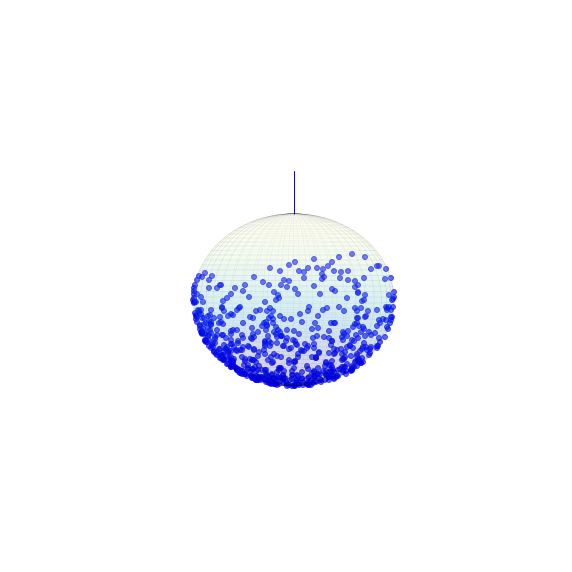

In [37]:
plot_particles(estructura_obs, 0, 0, 0)

In [20]:
%cd ..

/Users/ayano/Documents/Simulaciones/Foreign_Notebooks


In [16]:
!PWD

/Users/ayano/Documents/Simulaciones/Foreign_Notebooks


In [17]:
!mkdir OBSSIM03

In [18]:
%cd OBSSIM03/

/Users/ayano/Documents/Simulaciones/Foreign_Notebooks/OBSSIM03


KeyboardInterrupt: 

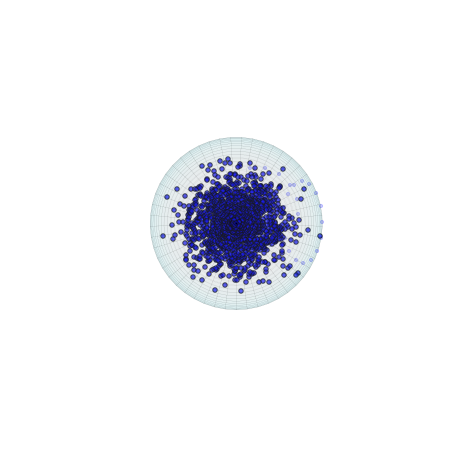

In [19]:
v1,v2,v3,v4,v5,v6,v7,v8 = simulacion_obs(mis_rs_obs, estructura_obs,0.5, pos_ini, 500,30, 2, 1e-3)

In [20]:
v = 1./np.sqrt(3)
size_std = np.pi/9
list_obs_estandar = [np.array([v,v,v]),np.array([-v,v,v]),np.array([v,-v,v]),np.array([-v,-v,v]),np.array([v,v,-v]),np.array([-v,v,-v]),np.array([v,-v,-v]),np.array([-v,-v,-v])]

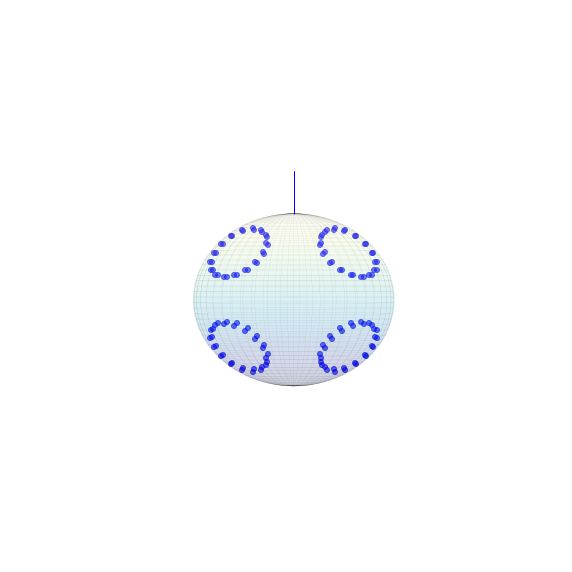

In [21]:
estruc_std = puntos_obs(list_obs_estandar, np.pi/9)
plot_particles(estruc_std,0,0,0)

In [23]:
!pwd

/Users/ayano/Documents/Simulaciones/Foreign_Notebooks/OBSSIM03


In [ ]:
w1,w2,w3,w4,w5,w6,w7,w8 = simulacion_obs(list_obs_estandar, estruc_std,np.pi/9, pos_ini, 600,30, 1, 1e-3)

In [86]:
!pwd

/Users/ayano/Documents/Simulaciones/Foreign_Notebooks


In [87]:
!mkdir Mean_Theta_Arccos_01

In [88]:
%cd Mean_Theta_Arccos_01/

/Users/ayano/Documents/Simulaciones/Foreign_Notebooks/Mean_Theta_Arccos_01


In [95]:
xw = np.array(v1)

ValueError: setting an array element with a sequence.

ValueError: setting an array element with a sequence.

NameError: name 'z1' is not defined

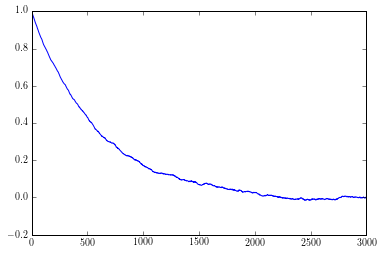

In [163]:
plt.plot(v8)

In [164]:
x8 = np.array(v8)

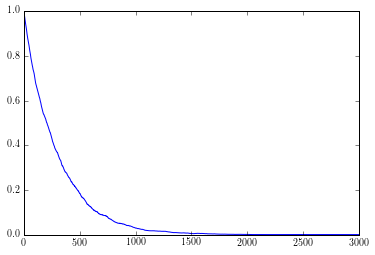

In [165]:
plt.plot(x8**2)

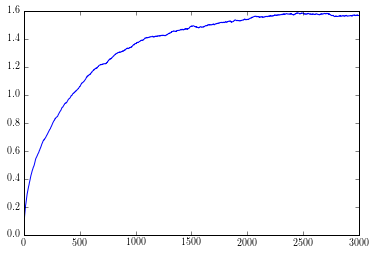

In [166]:
plt.plot(v3)

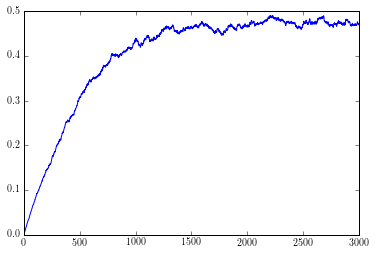

In [167]:
plt.plot(v5)

In [168]:
t_final = 3000
dt = 1e-3

In [169]:
npasos = t_final
suma = 0
tiempos = [0]
impulso = dt
for i in range(npasos):
    suma += impulso
    tiempos.append(suma)

In [175]:
A = np.vstack((tiempos, np.ones(len(tiempos)))).T
m, c = np.linalg.lstsq(A, np.log(np.array(v8)**2))[0]
print m, c

-4.26603835843 0.58891966769


In [176]:
Def = -m/4

In [177]:
Def

1.0665095896076646

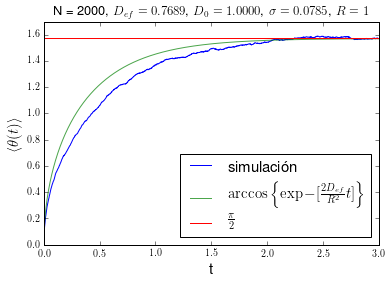

In [173]:
t = np.array(tiempos)
plt.rc('text', usetex=True)
plt.plot(t, v3 , label = r"simulaci\'on")
plt.plot(t,np.arccos(np.exp(-2*Def*t)), label = r"$\arccos{\left \{\exp{-[\frac{2D_{ef}}{R^2}t]}\right \}}$", alpha = 0.7)
plt.plot(t,np.pi/2*np.ones(len(t)), label = r"$\frac{\pi}{2}$")
plt.ylabel(r"$\langle \theta(t)\rangle$", fontsize = 15)
plt.ylim(0,1.7)
plt.xlabel(r"t",fontsize=15)
plt.legend(loc=4, fontsize = 15)
plt.title("N = 2000, $D_{ef} = 1.06$, $D_{0} = 1.0000$, $\sigma= 0.0785$, $R=1$ ", fontsize = 13)
plt.savefig("N2000_mean_Theta_t", dpi=120)

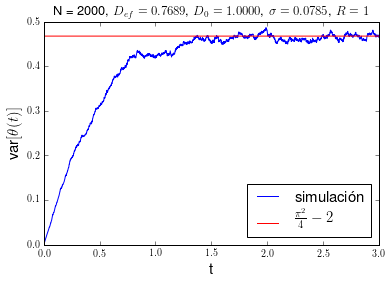

In [139]:
t = np.array(tiempos)
plt.rc('text', usetex=True)
plt.plot(t, v5 , label = r"simulaci\'on")
#plt.plot(t,np.arccos(np.exp(-2*Def*t)), label = r"$\arccos{(\exp{-[\frac{2D_{ef}}{R^2}t]})}$", alpha = 0.7)
plt.plot(t,(np.pi**2/4 - 2)*np.ones(len(t)), label = r"$\frac{\pi^2}{4} - 2$", color ="r")
plt.ylabel(r"$\mbox{var}[\theta(t)]$", fontsize = 15)
#plt.ylim(0,1.7)
plt.xlabel(r"t",fontsize=15)
plt.legend(loc=4, fontsize = 15)
plt.title("N = 2000, $D_{ef} = 0.7689$, $D_{0} = 1.0000$, $\sigma= 0.0785$, $R=1$ ", fontsize = 13)
plt.savefig("N2000_var_Theta_t", dpi=100)

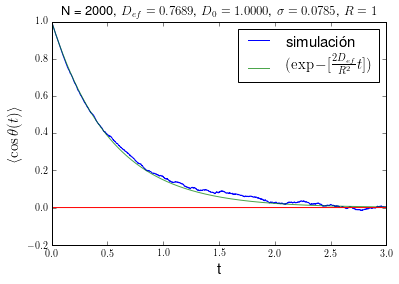

In [146]:
t = np.array(tiempos)
plt.rc('text', usetex=True)
plt.plot(t, v8 , label = r"simulaci\'on")
plt.plot(t, np.exp(-2*Def*t), label = r"$(\exp{-[\frac{2D_{ef}}{R^2}t])}$", alpha = 0.7)
plt.plot(t,np.zeros(len(t)), color ="r")
plt.ylabel(r"$\langle \cos{\theta(t)} \rangle$", fontsize = 15)
#plt.ylim(0,1.7)
plt.xlabel(r"t",fontsize=15)
plt.legend(loc=1, fontsize = 15)
plt.title("N = 2000, $D_{ef} = 0.7689$, $D_{0} = 1.0000$, $\sigma= 0.0625$, $R=1$ ", fontsize = 13)
plt.savefig("N2000_mean_cos_Theta_t", dpi=100)

In [116]:
!ls

N2000_mean_Theta_t.png theta.txt


In [174]:
100*2*np.pi*(1-np.cos(0.05))/(4*np.pi)

0.062486980251685864

In [57]:
len(tiempos)

6000

In [58]:
len(v4)

6000

In [65]:
type(tiempos)

list

In [37]:
t = np.array(tiempos)

In [68]:
type(t)

numpy.ndarray

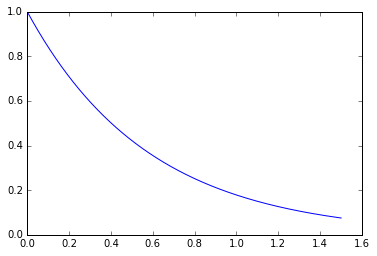

In [129]:
plt.plot(t,np.exp(-2*D*t))

### Más codigo

In [139]:
#Funcion que dada una lista de obstaculos, cuyas fronteras estan dadas por estructura_obs, una tamaño de obstaculo
# obs_size, una lista de posiciones iniciales pos_ini, una N de pasos a iterar la evolucion, con una presicion
# presicion en la particion de las geodesicas, un coeficiente de difusion libre D0, y un tamaño de paso dt: regres
#el coeficiente de difusion efectivo.
def sigma_D(mis_rs_obs, estructura_obs, obs_size, pos_ini, Npasos,presicion, D0, dt):
    
    v1,v2,v3,v4,v5,v6,v7,v8 = simulacion_obs(mis_rs_obs, estructura_obs,obs_size, pos_ini, Npasos,presicion, D0, dt)
    npasos = t_final
    suma = 0
    tiempos = [0]
    impulso = dt
    for i in range(Npasos):
        suma += impulso
        tiempos.append(suma)
    A = np.vstack((tiempos, np.ones(len(tiempos)))).T
    m, c = np.linalg.lstsq(A, np.log(np.array(v8)**2))[0]
    Defe = -m/4
    return Defe

In [140]:
def D_varianza(m, Nsigma, obs_size):
    Des = []
    for i in range(m):
        mis_rs_obs = obs_uniforme(Nsigma, 1, obs_size)
        Des.append(sigma_D(mis_rs_obs, estructura_obs, obs_size, pos_ini, Npasos,presicion, D0, dt))
        
    mean_Des = np.mean(Des)
    var_Des = np.var(Des)
    return mean_Des, var_Des

In [160]:
Npasos=100
presicion = 10
D0=1
dt=1e-3

In [ ]:
x, y = D_varianza(50,0,0.3)

In [165]:
x

0.98820377278055493

In [166]:
y

0.024480049066666835